In [1]:
import pandas as pd
pd.set_option('display.max_columns', 50)
pd.set_option('display.max_rows', 50)

In [2]:
file_trtresp = '/home/jiageng/Documents/fhr/data/CoMMpass_IA22_FlatFiles/MMRF_CoMMpass_IA22_STAND_ALONE_TRTRESP.tsv'
df_trtresp = pd.read_csv(file_trtresp, sep='\t', encoding='cp1252')
file_clin = '/home/jiageng/Documents/fhr/data/CoMMpass_IA22_FlatFiles/MMRF_CoMMpass_IA22_PER_PATIENT.tsv'
df_clin = pd.read_csv(file_clin, sep='\t')

In [3]:
names_all = df_clin.PUBLIC_ID.unique().tolist()
print(len(names_all))

1143


Identification of refractory to induction therapy or early relapse

In [4]:
# Clinical high risk
# 1. Number of patients with non-responsive to induction therapy (line 1, treatment group 1)
# 2. Or with progression within 18 months of start of any treatment, 
# 3. Or with progression within 6 months of autologous stem cell transplant
names_clinhr = \
df_trtresp.query("\
    (bestresp in ['Stable Disease','Progressive Disease'] and line==1 and trtgroup==1) or \
    (line==1 and trtgroup==1 and pddy > trtstdy and pddy - trtstdy < 548) or \
    (pddy > bmtx_day and pddy - bmtx_day < 365 and bmtx_rec==1 and bmtx_type=='Stem cell, Autologous')")\
        .PUBLIC_ID.unique().tolist()
len(names_clinhr)

186

In [5]:
tmp = pd.read_csv('/home/jiageng/Documents/fhr/data/SeqFISH Files_MMRF_CoMMpass_IA16a_LongInsert_Canonical_Ig_Translocations.txt', sep='\t')\
    .query("Study_Visit_iD.str.endswith('_BM')")\
    .assign(PUBLIC_ID=lambda x: x.Study_Visit_iD.apply(lambda x: '_'.join(x.split('_')[:2])))\
    .sort_values('Study_Visit_iD')\
    .groupby("PUBLIC_ID")\
    .head(n=1)
print(tmp.PUBLIC_ID.unique().size)
tmp.groupby(tmp['Study_Visit_iD'].str.split('_').str[2]).size()

904


Study_Visit_iD
1    872
2     19
3      8
4      5
dtype: int64

In [6]:
tmp = pd.read_csv('/home/jiageng/Documents/fhr/data/SeqFISH Files_MMRF_CoMMpass_IA16a_RNAseq_Canonical_Ig_Translocations.txt', sep='\t')\
    .query("Specimen_ID.str.endswith('_BM')")\
    .assign(PUBLIC_ID=lambda x: x.Specimen_ID.apply(lambda x: '_'.join(x.split('_')[:2])))\
    .sort_values('Specimen_ID')\
    .groupby("PUBLIC_ID")\
    .head(n=1)

print(tmp.PUBLIC_ID.unique().size)
tmp.groupby(tmp['Specimen_ID'].str.split('_').str[2]).size()

811


Specimen_ID
1    780
2     21
3      8
4      1
6      1
dtype: int64

In [7]:
# translocation-cyclin D classifications

use_RNAseq = False

if use_RNAseq:
    file_tc = '/home/jiageng/Documents/fhr/data/SeqFISH Files_MMRF_CoMMpass_IA16a_RNAseq_Canonical_Ig_Translocations.txt'
    df_tc = pd.read_csv(file_tc, sep='\t')\
        .query("Specimen_ID.str.endswith('_BM')")\
        .assign(PUBLIC_ID=lambda x: x.Specimen_ID.apply(lambda x: '_'.join(x.split('_')[:2])))\
        .sort_values('Specimen_ID')\
        .groupby("PUBLIC_ID")\
        .head(n=1)\
        .filter(regex='PUBLIC_ID|_Call')  # RNAseq 
    names_tc = df_tc.query('RNASeq_FGFR3_Call == 1 or RNASeq_MAF_Call == 1')['PUBLIC_ID'].unique() 
else:
    # use long insert WGS
    file_tc = '/home/jiageng/Documents/fhr/data/SeqFISH Files_MMRF_CoMMpass_IA16a_LongInsert_Canonical_Ig_Translocations.txt'
    df_tc = pd.read_csv(file_tc, sep='\t')\
        .query("Study_Visit_iD.str.endswith('_BM')")\
        .assign(PUBLIC_ID=lambda x: x.Study_Visit_iD.apply(lambda x: '_'.join(x.split('_')[:2])))\
        .sort_values('Study_Visit_iD')\
        .groupby("PUBLIC_ID")\
        .head(n=1)\
        .filter(regex='PUBLIC_ID|_CALL') 
    names_tc = df_tc.query('SeqWGS_WHSC1_CALL == 1 or SeqWGS_MAF_CALL == 1')['PUBLIC_ID'].unique() 

print('Patients with WGS canonical Ig info',len(df_tc.PUBLIC_ID.unique()))

# t(4;14) FGFR3 overexpression or t(14;16) c-MAF overexpression
print('Patients with t(4;14) or t(14;16)',names_tc.__len__())

Patients with WGS canonical Ig info 904
Patients with t(4;14) or t(14;16) 150


In [8]:
# bi-allelic TP53 deletion
# exome CN only has 1051 samples, while genome CN has 1121 samples
df_fish = '/home/jiageng/Documents/fhr/data/SeqFISH Files_MMRF_CoMMpass_IA22_genome_gatk_cna_seqFISH.tsv'
df_fish = pd.read_csv(df_fish, sep='\t').assign(PUBLIC_ID=lambda x: x['SAMPLE'].str.extract(r'(MMRF_\d{4})')).sort_values('SAMPLE').groupby('PUBLIC_ID').head(1)
print('df_fish',df_fish.shape)

# TP53 deletion. Either is the same.
names_del_tp53 = df_fish.loc[-0.2 > df_fish['SeqWGS_Cp_17p13'],'PUBLIC_ID'].unique() # 101
names_del_tp53 = df_fish.loc[df_fish['SeqWGS_Cp_17p13_20percent']==1,'PUBLIC_ID'].unique() # 103

# Deep TP53 deletion
# There are no individuals with -2 > log2FC 
names_deep_del_tp53 = df_fish.loc[-2 > df_fish['SeqWGS_Cp_17p13'],'PUBLIC_ID'].unique() # 0
assert len(names_deep_del_tp53) == 0

# TP53 mutations
file_mut = '/home/jiageng/Documents/fhr/data/IGV Downloads_MMRF_CoMMpass_IA22_exome_vcfmerger2_IGV_All_Canonical_NS_Variants.mut'
df_mut = pd.read_csv(file_mut, sep='\t')
df_mut = df_mut[df_mut['sample'].str.endswith('BM_CD138pos')].assign(PUBLIC_ID=lambda x: x['sample'].str.extract(r'(MMRF_\d{4})'))

names_mut_tp53 = df_mut.query('chr=="chr17" and GENE=="TP53"')['PUBLIC_ID'].unique()

# TP53 LOH
file_baf = '/home/jiageng/Documents/fhr/data/Loss of Heterozygosity Files_MMRF_CoMMpass_IA22_exome_gatk_baf.seg'
df_baf = pd.read_csv(file_baf, sep='\t').assign(PUBLIC_ID=lambda x: x['SAMPLE'].str.extract(r'(MMRF_\d{4})'))
TP53_start=7661779
TP53_end=7687564
# LEN=(TP53_end-TP53_start+1)/2
LEN=1000
# select where (Start, End) overlaps with (TP53_start, TP53_end) by at least @LEN positions
df_baf_tp53 = df_baf.query("Chromosome=='chr17' and ((Start < @TP53_start and End + @LEN > @TP53_start) or (Start < @TP53_end - @LEN and End >= @TP53_end) or (Start > @TP53_start and End < @TP53_end and (End - Start) >= @LEN))")
# LOH defined as B-allele frequency of <0.25 (since it ranges from 0 to 0.5)
names_loh_tp53 = df_baf_tp53.loc[df_baf_tp53['Segment_Mean'] < 0.25, 'PUBLIC_ID'].unique() # 104

# Double Hit TP53 events
# deciding not to include deletion + LOH as a bi-allelic event
biallelic_tp53_type1 = set(names_mut_tp53).intersection(set(names_del_tp53))
biallelic_tp53_type2 = set(names_mut_tp53).intersection(set(names_loh_tp53))
# biallelic_tp53_type3 = set(names_del_tp53).intersection(set(names_loh_tp53))
biallelic_tp53 = biallelic_tp53_type1.union(biallelic_tp53_type2) #.union(biallelic_tp53_type3)

print('Patients with TP53 BAF info',df_baf_tp53['PUBLIC_ID'].unique().__len__()) # 974
print('Patients with TP53 copy number info',df_fish['PUBLIC_ID'].unique().__len__()) # 892
print('Patients with TP53 mutation info',df_mut['PUBLIC_ID'].unique().__len__()) # 974
print(f"Patients with known bi-allelic loss of TP53: {len(biallelic_tp53)} ({len(biallelic_tp53)/892*100:.2f}%)")
print(f"Breakdown: type 1: {len(biallelic_tp53_type1)}, type 2: {len(biallelic_tp53_type2)}")


df_fish (924, 175)
Patients with TP53 BAF info 974
Patients with TP53 copy number info 924
Patients with TP53 mutation info 974
Patients with known bi-allelic loss of TP53: 39 (4.37%)
Breakdown: type 1: 31, type 2: 35


In [9]:
# 1q gain and ISS3
names_iss3 = df_clin.loc[df_clin['D_PT_iss']==3,'PUBLIC_ID'].unique() # 311
names_gain1q = df_fish.loc[df_fish['SeqWGS_Cp_1q21'] > 0.2,'PUBLIC_ID'].unique() # 385 # SeqExome
names_gain1q_iss3 = set(names_iss3).intersection(set(names_gain1q)) # 110

In [10]:
# rescue the missing TP53 deletion info using BAF info

df_baf_fish = df_baf_tp53.merge(df_fish.drop(columns=['SAMPLE']),how='left',on='PUBLIC_ID')
df_baf_only = df_baf_fish[df_baf_fish['SeqWGS_Cp_17p13'].isna()]

# these have two copies of TP53
names_tp53_baf_derived_normal_cn = set(df_baf_only[df_baf_only['Segment_Mean'] > 0.45].PUBLIC_ID)


FHR calling attempt 1

This is not exactly accurate because individuals with missing data are considered lacking the features

e.g. Those without TP53 copy number data (FISH) are assumed to be TP53-copy number neutral

In [11]:
# FHR calling pipeline
names_ghr = set(names_tc).union(set(names_gain1q_iss3)).union(set(biallelic_tp53))
print('GHR',len(names_ghr))
names_fhr = set(names_clinhr).difference(names_ghr)
print('FHR',len(names_fhr))
names_sr = set(names_all).difference(names_ghr).difference(names_fhr)
print('SR',len(names_sr))

GHR 265
FHR 140
SR 740


FHR features in OncoPrint format
public_id feature_1_yes/no/missing ... feature_n_yes/no/missing (1=yes, 0=no, -1=missing)

In [41]:
names_refractory = df_trtresp.query("(bestrespsh in ['SD','PD'] and line==1 and trtgroup==1)").PUBLIC_ID.unique()
names_relapse = df_trtresp.query("(line==1 and trtgroup==1 and pddy > trtstdy and pddy - trtstdy < 548) or (pddy > bmtx_day and pddy - bmtx_day < 365 and bmtx_rec==1 and bmtx_type=='Stem cell, Autologous')").PUBLIC_ID.unique()
names_clinhr = set(names_refractory).union(set(names_relapse)).intersection(set(names_all))

names_tc_all = df_tc.PUBLIC_ID.unique()
names_cn_all = set(df_fish.PUBLIC_ID).union(set(names_tp53_baf_derived_normal_cn))
names_baf_all = df_baf.PUBLIC_ID.unique()
names_mut_all = df_mut.PUBLIC_ID.unique()

names_iss_all = df_clin.dropna(subset='D_PT_iss').PUBLIC_ID.unique()

names_tp53_all = set(names_cn_all).union(set(names_mut_all)).union(set(names_baf_all))
len(names_tp53_all)
names_tp53_mut_del = set(names_mut_tp53).intersection(set(names_del_tp53))
names_tp53_mut_loh = set(names_mut_tp53).intersection(set(names_loh_tp53))
names_tp53_biallelic = set(names_tp53_mut_del).union(set(names_tp53_mut_loh))
data = {
    'Refractory': [1 if name in names_refractory else 0 for name in names_all],
    'Early relapse': [1 if name in names_relapse else 0 for name in names_all],
    't(4;14)/t(14;16)': [1 if name in names_tc else 0 if name in names_tc_all else -1 for name in names_all],
    'Double Hit TP53': [1 if name in names_tp53_biallelic else 0 if name in names_tp53_all else -1 for name in names_all],
    'TP53 NS Mut': [1 if name in names_mut_tp53 else 0 if name in names_mut_all else -1 for name in names_all],
    'TP53 Del': [1 if name in names_del_tp53 else 0 if name in names_cn_all else -1 for name in names_all],
    'TP53 LoH': [1 if name in names_loh_tp53 else 0 if name in names_baf_all else -1 for name in names_all],
    'ISS III': [1 if name in names_iss3 else 0 if name in names_iss_all else -1 for name in names_all],
    'Gain1q': [1 if name in names_gain1q else 0 if name in names_cn_all else -1 for name in names_all]
}

df_fhr = pd.DataFrame(data,index=names_all)
df_fhr.index.name='PUBLIC_ID'

In [42]:
# individuals with data present across all genomic features
names_ghr_all = set(names_tc_all).intersection(set(names_cn_all)).intersection(set(names_baf_all)).intersection(set(names_mut_all)).intersection(set(names_iss_all).union(names_gain1q))
names_ghr = set(names_tc).union(set(names_tp53_biallelic)).union((set(names_iss3).union(names_gain1q))).intersection(names_ghr_all)

names_fhr = set(names_clinhr).difference(names_ghr)

In [43]:
# get a quick count of how many FHR patients are in the dataset
labels_fhr = [1 if name in names_fhr else -1 for name in names_all]
pd.Series(labels_fhr).value_counts()

-1    1053
 1      90
Name: count, dtype: int64

In [44]:
labels_all = [2 if name in names_fhr else 1 if (name in names_ghr and name in names_ghr_all) else 0 for name in names_all]
pd.Series(labels_all).value_counts()

0    538
1    515
2     90
Name: count, dtype: int64

In [45]:
from matplotlib import pyplot as plt
import numpy as np
from matplotlib.colors import ListedColormap

# for oncoplot side axes
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable
from matplotlib.patches import Patch


In [46]:
# Order the samples using the oncoplot algorithm
def oncoplot_ordering(data,extra_covariates=[],prioritize_covariates=False):
    # Define a recursive function to order the data
    def recursive_ordering(data, depth=0):
        if depth >= data.shape[1]:
            return data.index.tolist()
        
        # Order columns by column-wise sum
        primary_col = ordered_columns[depth]
                
        # The remaining are IGH partner columns
        # Divide observations into groups based on the primary column
        
        ordered_indices = []
        
        for value in sorted(data[primary_col].unique())[::-1]:
            # subset to observations with the same value
            group_v = data[data[primary_col] == value]
            # Recursively order within each group
            ordered_indices_v = recursive_ordering(group_v, depth + 1)
            # Combine the ordered indices
            ordered_indices.extend(ordered_indices_v)
        
        return ordered_indices
    
    # Start the recursive ordering
    # Order by number of carriers
    # ordered_columns = (data==1).sum(axis=0).sort_values(ascending=False).index
    heatmap_data = data.drop(columns=extra_covariates)
    ordered_heatmap_columns = (heatmap_data==1).sum(axis=0).sort_values(ascending=False).index
    
    # Order additional columns appear last
    if prioritize_covariates:    
        ordered_columns = pd.Index(extra_covariates).append(ordered_heatmap_columns)
    else:
        ordered_columns = ordered_heatmap_columns.append(pd.Index(extra_covariates))
    
    ordered_indices = recursive_ordering(data.loc[:, ordered_columns])
    return data.loc[ordered_indices, ordered_columns]


In [47]:
df_fhr_ordered = oncoplot_ordering(df_fhr)

In [48]:
df_fhr_ordered.shape

(1143, 9)

In [49]:
(df_fhr_ordered==1).sum()

Gain1q              339
ISS III             311
Early relapse       152
t(4;14)/t(14;16)    149
TP53 LoH            100
TP53 Del             92
Refractory           57
TP53 NS Mut          54
Double Hit TP53      38
dtype: int64

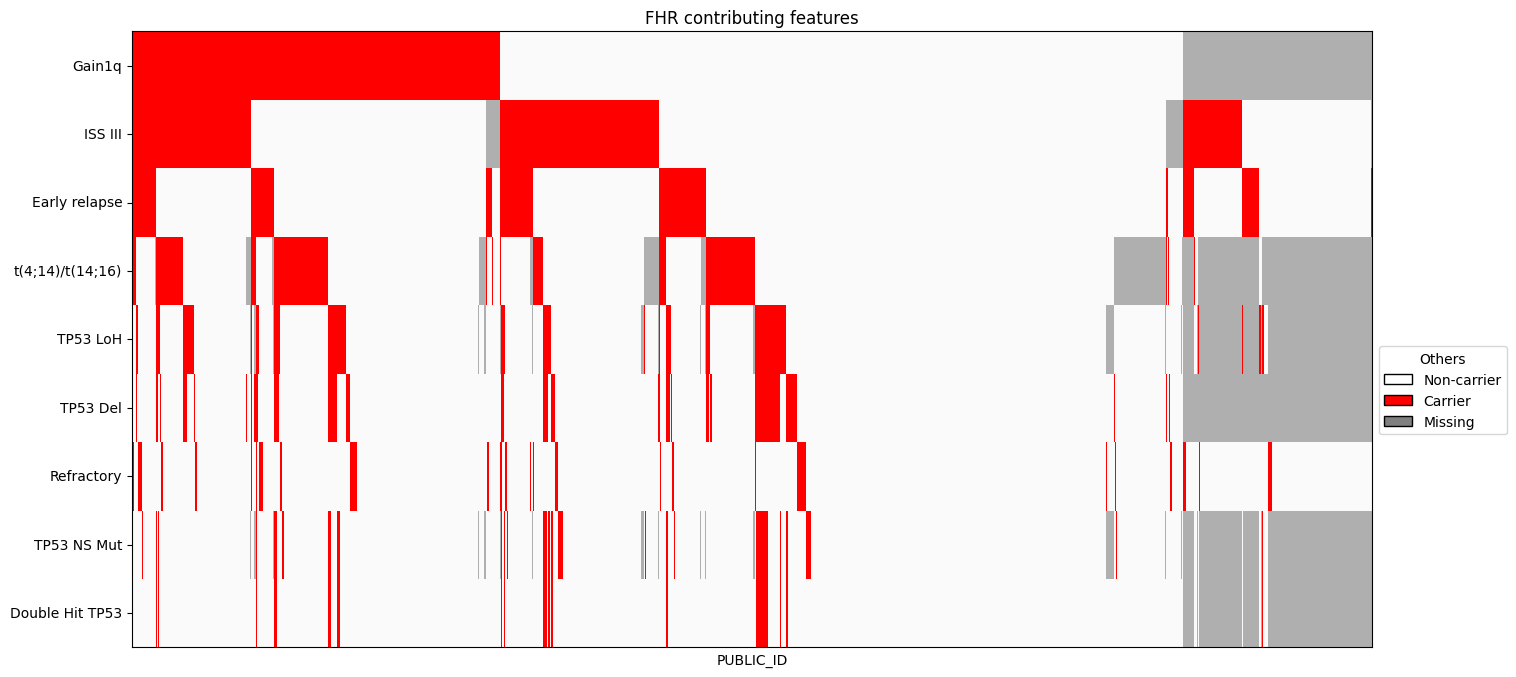

In [50]:
import seaborn as sns
fig,ax=plt.subplots()
fig.set_size_inches(16,8)
ax=sns.heatmap(df_fhr_ordered.T, cmap=ListedColormap(['#AFAFAF','#FAFAFA','red']), cbar=False, xticklabels=False,ax=ax)
ax.set_title('FHR contributing features')

# add black frame around heatmap
for spine in ax.spines.values():
    spine.set_visible(True)
    
# Create legend for main heatmap
main_legend_elements = [
    Patch(facecolor='white', edgecolor='black', label='Non-carrier'),
    Patch(facecolor='red', edgecolor='black', label='Carrier'),
    Patch(facecolor='grey', edgecolor='black', label='Missing'),
]
ax.legend(handles=main_legend_elements, title='Others', bbox_to_anchor=(1, 0.5), loc='upper left', frameon=True)

# fig.savefig('../fhr-heatmap-full.svg')

New method which does not use set to assign FHR, considers case by case

In [51]:
df_fhr_ann = df_fhr.copy()
df_fhr_ann.loc[:,'risk'] = pd.Series(dtype=int)

# Manually call FHR, GHR, and SR
for i,x in df_fhr_ann.iterrows():
    # i is MMRF_1014
    if (x['Refractory']==1 or x['Early relapse']==1) \
            and x['t(4;14)/t(14;16)']==0 \
            and x['Double Hit TP53']==0 \
            and (x['ISS III']==0 or x['Gain1q']==0):
                df_fhr_ann.loc[i,'risk'] = 2 # 'FHR'
    elif (x['Refractory']==0 and x['Early relapse']==0) \
            and x['t(4;14)/t(14;16)']==0 \
            and x['Double Hit TP53']==0 \
            and (x['ISS III']==0 or x['Gain1q']==0):
                df_fhr_ann.loc[i,'risk'] = 0 # 'SR'
    elif (x['t(4;14)/t(14;16)']==1 or x['Double Hit TP53']==1 or (x['ISS III']==1 and x['Gain1q']==1)):
        df_fhr_ann.loc[i,'risk'] = 1 # 'GHR'
    else:
        df_fhr_ann.loc[i,'risk'] = -1 # 'NA'

df_fhr_ann['risk'] = df_fhr_ann['risk'].astype(int)
df_fhr_ann['risk'].value_counts()

risk
 0    528
 1    263
-1    259
 2     93
Name: count, dtype: int64

Text(0.5, 1.0, 'CoMMpass patients categorized by risk')

<Figure size 640x480 with 0 Axes>

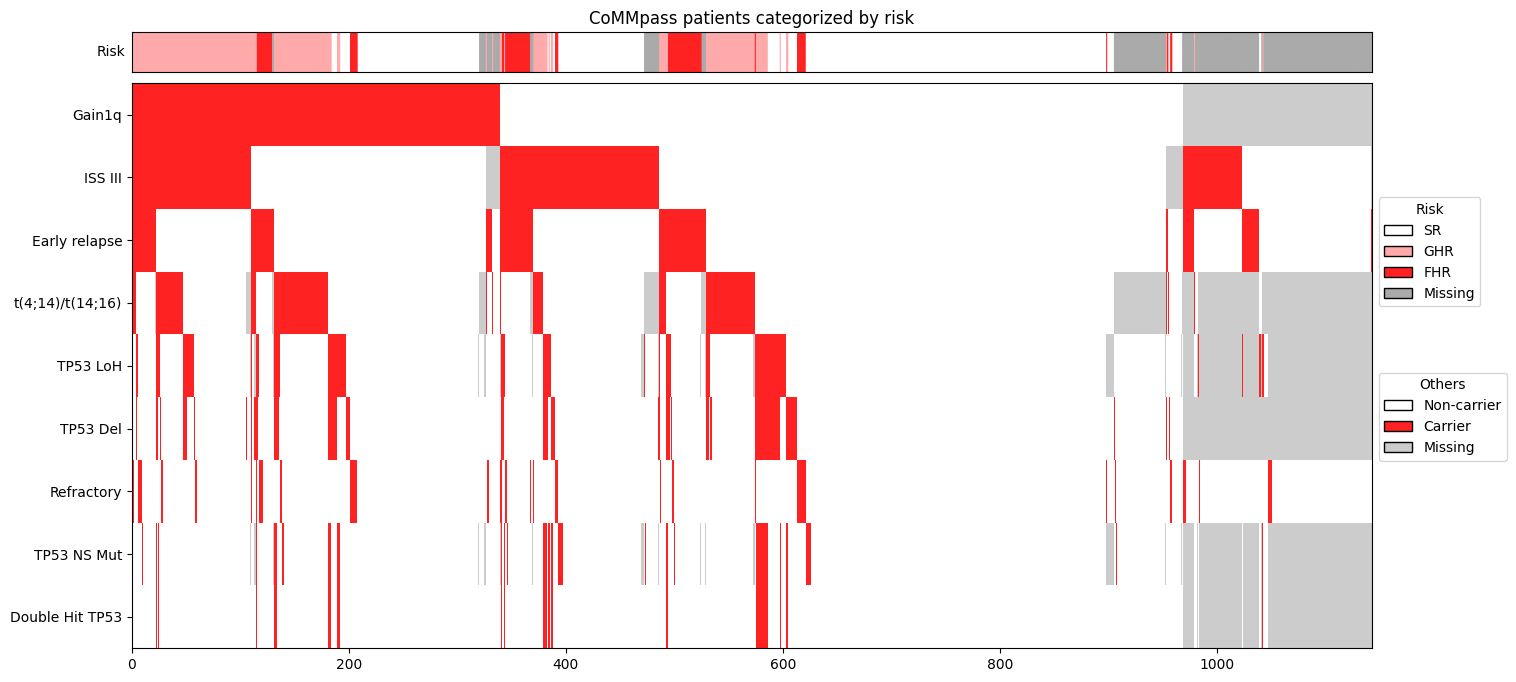

In [52]:
# Create ordered data with secondary labels
df_fhr_ann_ordered = oncoplot_ordering(df_fhr_ann, extra_covariates=['risk'],prioritize_covariates=False)

ordered_data = df_fhr_ann_ordered.drop(columns='risk')
ordered_colnames = ordered_data.columns
# Create OncoPrint
plt.clf(); 
fig,ax = plt.subplots()
fig.set_size_inches(16,8)

xlim = ax.set_xlim(0,ordered_data.shape[0])
ylim = ax.set_ylim(0,ordered_data.shape[1])

# instead of using axes.imshow, use axes.add_patch to draw rectangles
for i in range(ordered_data.shape[0]):
    for j in range(ordered_data.shape[1]):
        # draw a thin rectangle for each 1 in the data
        if ordered_data.iloc[i, j] == 1:
            ax.add_patch(
                plt.Rectangle(
                    (i, ordered_data.shape[1]-1-j), 1, 1, linewidth=0, color='#FF2222'
                )
            )
        elif ordered_data.iloc[i,j] == -1:
            ax.add_patch(
                plt.Rectangle(
                    (i, ordered_data.shape[1]-1-j), 1, 1, linewidth=0, color='#CCCCCC'
                )
            )

# offset y-axis ticks to center them
ax.set_yticks(np.arange(len(ordered_colnames))+0.5)
# need to reverse the order of the labels this time
ax.set_yticklabels(ordered_colnames[::-1], rotation=0)

# Create legend for main heatmap
main_legend_elements = [
    Patch(facecolor='white', edgecolor='black', label='Non-carrier'),
    Patch(facecolor='#FF2222', edgecolor='black', label='Carrier'),
    Patch(facecolor='#CCCCCC', edgecolor='black', label='Missing'),
]
ax.legend(handles=main_legend_elements, title='Others', bbox_to_anchor=(1, 0.5), loc='upper left', frameon=True)

# Add secondary annotations
ax = make_axes_locatable(ax)

# Create a new axes for the secondary annotation
ax_fhr = ax.append_axes("top", size="7%", pad="2%")

# Define a colormap for the risk types
fhr_cmap = ListedColormap(['#AAAAAA','white','#FFAAAA','#FF2222'])


# Plot the 1D heatmap for risk types
fhr_values = df_fhr_ann_ordered['risk'].values

ax_fhr.imshow(fhr_values[np.newaxis,:], aspect='auto', cmap=fhr_cmap)

# Remove ticks
ax_fhr.set_xticks([])
ax_fhr.set_yticks([])


# Add y-axis label for secondary annotation
ax_fhr.set_ylabel('Risk', rotation=0, labelpad=5, va='center', ha='right')

# Create legend for FHR
fhr_legend_elements = [
    Patch(facecolor='white', edgecolor='black', label='SR'),
    Patch(facecolor='#FFAAAA', edgecolor='black', label='GHR'),
    Patch(facecolor='#FF2222', edgecolor='black', label='FHR'),
    Patch(facecolor='#AAAAAA', edgecolor='black', label='Missing'),
]
ax_fhr.legend(handles=fhr_legend_elements, title='Risk', bbox_to_anchor=(1, -3), loc='upper left', frameon=True)

plt.title('CoMMpass patients categorized by risk')

# fig.savefig('../fhr-heatmap-full-ann.svg')

Remove early relapse and refractory from the main heatmap and show them as covariates

Text(0.5, 1.0, 'CoMMpass patients categorized by risk')

<Figure size 640x480 with 0 Axes>

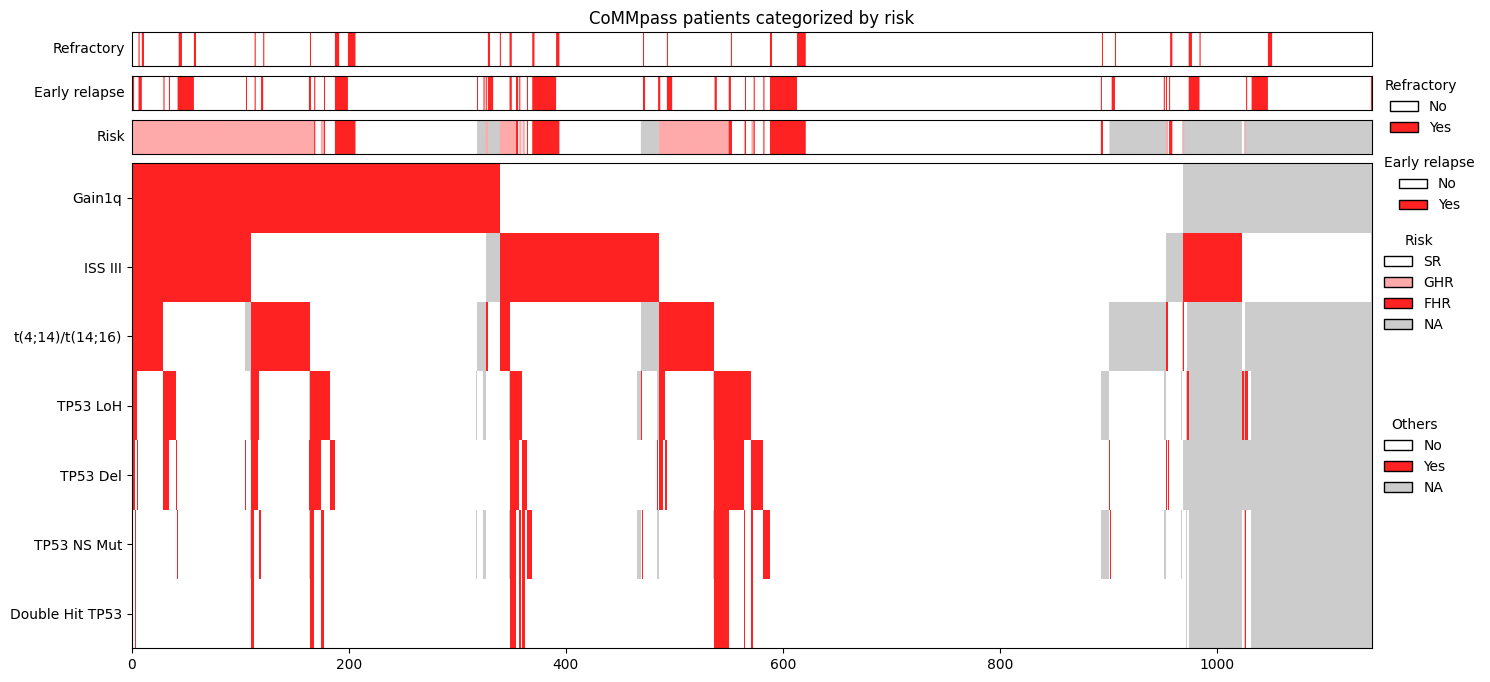

In [65]:
# Create ordered data with covariates
covariates = ['risk','Early relapse','Refractory']
df_fhr_ann_ordered = oncoplot_ordering(df_fhr_ann, extra_covariates=covariates,prioritize_covariates=False)

ordered_data = df_fhr_ann_ordered.drop(columns=covariates)
ordered_colnames = ordered_data.columns

# Create OncoPrint with side axes
plt.clf(); 
fig,ax = plt.subplots()
fig.set_size_inches(16,8)

xlim = ax.set_xlim(0,ordered_data.shape[0])
ylim = ax.set_ylim(0,ordered_data.shape[1])

color_red = "#FF2222"
color_grey = "#CCCCCC"
color_pink = "#FFAAAA"

# instead of using axes.imshow, use axes.add_patch to draw rectangles
for i in range(ordered_data.shape[0]):
    for j in range(ordered_data.shape[1]):
        # draw a thin rectangle for each 1 in the data
        if ordered_data.iloc[i, j] == 1:
            ax.add_patch(
                plt.Rectangle(
                    (i, ordered_data.shape[1]-1-j), 1, 1, linewidth=0, color=color_red
                )
            )
        elif ordered_data.iloc[i,j] == -1:
            ax.add_patch(
                plt.Rectangle(
                    (i, ordered_data.shape[1]-1-j), 1, 1, linewidth=0, color=color_grey
                )
            )

# offset y-axis ticks to center them
ax.set_yticks(np.arange(len(ordered_colnames))+0.5)
# need to reverse the order of the labels this time
ax.set_yticklabels(ordered_colnames[::-1], rotation=0)


# Create legend for main heatmap
main_legend_elements = [
    Patch(facecolor='white', edgecolor='black', label='No'),
    Patch(facecolor=color_red, edgecolor='black', label='Yes'),
    Patch(facecolor=color_grey, edgecolor='black', label='NA'),
]
ax.legend(handles=main_legend_elements, title='Others', bbox_to_anchor=(1, 0.5), loc='upper left', frameon=False)

# Add secondary annotations
ax = make_axes_locatable(ax)

# Create a new axes for the secondary annotation
ax_fhr = ax.append_axes("top", size="7%", pad="2%")
ax_early = ax.append_axes("top", size="7%", pad="2%") # early relapse
ax_refrac = ax.append_axes("top", size="7%", pad="2%") # refractory

# Define a colormap for the risk types
cmap_fhr = ListedColormap([color_grey,'white',color_pink,color_red])
cmap_early = ListedColormap(['white',color_red])
cmap_refrac = ListedColormap(['white',color_red])

# Plot the 1D heatmap for risk types
values_fhr = df_fhr_ann_ordered['risk'].values
values_early = df_fhr_ann_ordered['Early relapse'].values
values_refrac = df_fhr_ann_ordered['Refractory'].values

ax_fhr.imshow(values_fhr[np.newaxis,:], aspect='auto', cmap=cmap_fhr)
ax_early.imshow(values_early[np.newaxis,:], aspect='auto', cmap=cmap_early)
ax_refrac.imshow(values_refrac[np.newaxis,:], aspect='auto', cmap=cmap_refrac)

# Remove ticks
ax_fhr.set_xticks([])
ax_fhr.set_yticks([])
ax_early.set_xticks([])
ax_early.set_yticks([])
ax_refrac.set_xticks([])
ax_refrac.set_yticks([])

# Add y-axis label for secondary annotation
ax_fhr.set_ylabel('Risk', rotation=0, labelpad=5, va='center', ha='right')
ax_early.set_ylabel('Early relapse', rotation=0, labelpad=5, va='center', ha='right')
ax_refrac.set_ylabel('Refractory', rotation=0, labelpad=5, va='center', ha='right')

# Create legend for FHR
legend_elements_fhr = [
    Patch(facecolor='white', edgecolor='black', label='SR'),
    Patch(facecolor=color_pink, edgecolor='black', label='GHR'),
    Patch(facecolor=color_red, edgecolor='black', label='FHR'),
    Patch(facecolor=color_grey, edgecolor='black', label='NA'),
]
ax_fhr.legend(handles=legend_elements_fhr, title='Risk', bbox_to_anchor=(1, -2), loc='upper left', frameon=False)

# Create legend for Early relapse
legend_elements_early = [
    Patch(facecolor='white', edgecolor='black', label='No'),
    Patch(facecolor=color_red, edgecolor='black', label='Yes'),
]
ax_early.legend(handles=legend_elements_early, title='Early relapse', bbox_to_anchor=(1, -1), loc='upper left', frameon=False)

# Create legend for Refractory
legend_elements_refrac = [
    Patch(facecolor='white', edgecolor='black', label='No'),
    Patch(facecolor=color_red, edgecolor='black', label='Yes'),
]
ax_refrac.legend(handles=legend_elements_refrac, title='Refractory', bbox_to_anchor=(1, 0), loc='upper left', frameon=False)

plt.title('CoMMpass patients categorized by risk')

# fig.savefig('../fhr-heatmap-full-ann-rr.svg')

Remove the constituent TP53 features

<Figure size 640x480 with 0 Axes>

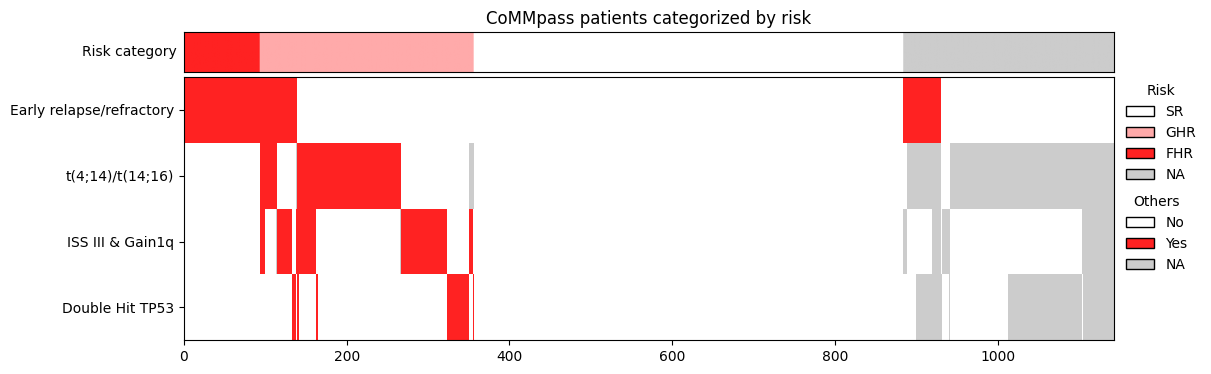

In [62]:
# Remove intermediate features that are not directly used in FHR calling
cols_to_drop = ['TP53 Del','TP53 LoH','TP53 NS Mut','ISS III','Gain1q','Early relapse','Refractory']
df_fhr_abbrv_ann = df_fhr_ann.assign(**{
    'ISS III & Gain1q': lambda xs: xs.apply(lambda x: 1 if x['Gain1q']==1 and x['ISS III']==1 else 0 if (x['Gain1q']==0 or x['ISS III']==0) else -1, axis=1),
    'Early relapse/refractory': lambda xs: xs.apply(lambda x: 1 if x['Refractory']==1 or x['Early relapse']==1 else 0, axis=1)}).drop(columns=cols_to_drop)

# Create ordered data with covariates
covariates = ['risk']
df_fhr_ann_ordered = oncoplot_ordering(df_fhr_abbrv_ann, extra_covariates=covariates,prioritize_covariates=True)

ordered_data = df_fhr_ann_ordered.drop(columns=covariates)
ordered_colnames = ordered_data.columns

# Create OncoPrint with side axes
plt.clf(); 

fig,ax = plt.subplots()
fig.set_size_inches(12,4)

xlim = ax.set_xlim(0,ordered_data.shape[0])
ylim = ax.set_ylim(0,ordered_data.shape[1])

color_red = "#FF2222"
color_grey = "#CCCCCC"
color_pink = "#FFAAAA"

# instead of using axes.imshow, use axes.add_patch to draw rectangles
for i in range(ordered_data.shape[0]):
    for j in range(ordered_data.shape[1]):
        # draw a thin rectangle for each 1 in the data
        if ordered_data.iloc[i, j] == 1:
            ax.add_patch(
                plt.Rectangle(
                    (i, ordered_data.shape[1]-1-j), 1, 1, linewidth=0, color=color_red
                )
            )
        elif ordered_data.iloc[i,j] == -1:
            ax.add_patch(
                plt.Rectangle(
                    (i, ordered_data.shape[1]-1-j), 1, 1, linewidth=0, color=color_grey
                )
            )

# offset y-axis ticks to center them
ax.set_yticks(np.arange(len(ordered_colnames))+0.5)
# need to reverse the order of the labels this time
ax.set_yticklabels(ordered_colnames[::-1], rotation=0)

# Create legend for main heatmap
main_legend_elements = [
    Patch(facecolor='white', edgecolor='black', label='No'),
    Patch(facecolor=color_red, edgecolor='black', label='Yes'),
    Patch(facecolor=color_grey, edgecolor='black', label='NA'),
]
ax.legend(handles=main_legend_elements, title='Others', bbox_to_anchor=(1.0, 0.6), loc='upper left', frameon=False)

# Add secondary annotations
ax = make_axes_locatable(ax)

# Create a new axes for the secondary annotation
ax_fhr = ax.append_axes("top", size="15%", pad="2%")

# Define a colormap for the risk types
cmap_fhr = ListedColormap([color_grey,'white',color_pink,color_red])

# Plot the 1D heatmap for risk types
values_fhr = df_fhr_ann_ordered['risk'].values

ax_fhr.imshow(values_fhr[np.newaxis,:], aspect='auto', cmap=cmap_fhr)

# Remove ticks
ax_fhr.set_xticks([])
ax_fhr.set_yticks([])

# Add y-axis label for secondary annotation
ax_fhr.set_ylabel('Risk category', rotation=0, labelpad=5, va='center', ha='right')

# Create legend for FHR
legend_elements_fhr = [
    Patch(facecolor='white', edgecolor='black', label='SR'),
    Patch(facecolor=color_pink, edgecolor='black', label='GHR'),
    Patch(facecolor=color_red, edgecolor='black', label='FHR'),
    Patch(facecolor=color_grey, edgecolor='black', label='NA'),
]
ax_fhr.legend(handles=legend_elements_fhr, title='Risk', bbox_to_anchor=(1.0, 0), loc='upper left', frameon=False)

plt.title('CoMMpass patients categorized by risk')

fig.savefig('../fhr-heatmap-abbrv-ann.svg')


In [58]:
df_fhr_ann.to_csv('../fhr-annotations-raw.tsv',sep='\t')

In [59]:
df_fhr_abbrv_ann.to_csv('../fhr-annotations.tsv',sep='\t')

In [60]:
df_fhr_ann.iloc[:,:-1].apply(pd.Series.value_counts)

,Refractory,Early relapse,t(4;14)/t(14;16),Double Hit TP53,TP53 NS Mut,TP53 Del,TP53 LoH,ISS III,Gain1q
-1,NaN,NaN,251,162,185,174,185,30,174
0,1086.0,991.0,743,943,904,877,858,802,630
1,57.0,152.0,149,38,54,92,100,311,339


In [61]:
df_fhr_abbrv_ann.apply(pd.Series.value_counts)

,t(4;14)/t(14;16),Double Hit TP53,risk,ISS III & Gain1q,Early relapse/refractory
-1,251.0,162.0,259,68.0,NaN
0,743.0,943.0,528,965.0,957.0
1,149.0,38.0,263,110.0,186.0
2,NaN,NaN,93,NaN,NaN
